## Load the necessary libraries

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


# Import Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


### Prepare CIFAR-10 Datase

In [2]:
# Prepare Dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=2)

# Define the classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


0it [00:00, ?it/s]

170500096it [00:06, 27487980.88it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data


#### Visualize few data

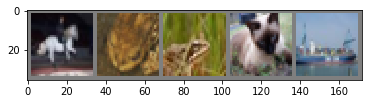

   horse     frog     frog      cat     ship


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(5)))

## Define the ResNet architecture

In [0]:
## Define the ResNet architecture from the paper

# Define convolution operator
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)

# Main basic block that will be repeated
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, normalize=None, activation=nn.ReLU(inplace=True), batchnorm=True):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        # we define batchnorm but filter it out in forward
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Enables us to use different type of activation
        self.activation = activation
        # Batchnorm flag
        self.batchnorm = batchnorm
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # 
        self.normalize = normalize
        # self.initilize_weight()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        # Perform batchnorm if it is enabled
        if self.batchnorm:
          out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        # Perform batchnorm if it is enabled
        if self.batchnorm:
          out = self.bn2(out)
        # Change the shape of the layer to combine the residual
        if self.normalize:
            residual = self.normalize(x)
        out += residual
        out = self.activation(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, activation=nn.ReLU(inplace=True), batchnorm=True):
        super(ResNet, self).__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        # First change from 3 channel input to 16 channel
        self.in_channels = 16
        # This conv layers converts RBG to 16 channel
        self.conv = conv3x3(3, 16)
        self.bn1 = nn.BatchNorm2d(16)
        # Create residual basic blocks
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        normalize = None
        
        # Define a layer to adjust the shape so residue can be added
        if (stride != 1) or (self.in_channels != out_channels):
            normalize = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        
        # Holds the basic residue block
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, normalize, self.activation, self.batchnorm))
        self.in_channels = out_channels
        
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels, 1, None, self.activation, self.batchnorm))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        
        # Perform batchnorm if it is enabled
        if self.batchnorm:
          out = self.bn1(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

### Define hyper-parameters

In [5]:
# batch_size, epoch and iteration
batch_size = 64
num_epochs = 30

# Create ResNet
net_args = {
    "block": BasicBlock,
    "layers": [2, 2, 2, 2]
}
model = ResNet(**net_args)

# Move the model to CUDA
model.to(device)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# Adam Optimizer
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


## Train the ResNet model

In [6]:
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = Variable(images).to(device)
        labels = Variable(labels).to(device)           
        # Clear gradients
        optimizer.zero_grad()    
        # Forward propagation
        outputs = model(train)        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)        
        # Calculating gradients
        loss.backward()        
        # Update parameters
        optimizer.step()        
        count += 1      
        if count % 100 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:               
                # Inference
                images = Variable(images).to(device)
                labels = Variable(labels).to(device)  
                outputs = model(images)                
                # Get predictions
                predicted = torch.max(outputs.data, 1)[1]             
                # Total number of labels
                total += labels.size(0)              
                correct += (predicted == labels).sum()         
            accuracy = 100 * correct / float(total)         
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 100 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))
    # Save the model in each epoch
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/tmp/cifar10.pth')


Iteration: 100  Loss: 1.8487906455993652  Accuracy: 44.02000045776367 %
Iteration: 200  Loss: 1.3433107137680054  Accuracy: 49.68000030517578 %
Iteration: 300  Loss: 1.396454930305481  Accuracy: 54.03999710083008 %
Iteration: 400  Loss: 1.2082672119140625  Accuracy: 55.40999984741211 %
Iteration: 500  Loss: 1.1575312614440918  Accuracy: 60.04999923706055 %
Iteration: 600  Loss: 0.9762148857116699  Accuracy: 61.279998779296875 %
Iteration: 700  Loss: 0.9983352422714233  Accuracy: 62.0099983215332 %
Iteration: 800  Loss: 0.8136875033378601  Accuracy: 64.15999603271484 %
Iteration: 900  Loss: 0.7326785922050476  Accuracy: 65.4000015258789 %
Iteration: 1000  Loss: 0.8761345148086548  Accuracy: 66.3699951171875 %
Iteration: 1100  Loss: 1.1503349542617798  Accuracy: 66.33999633789062 %
Iteration: 1200  Loss: 0.7189761996269226  Accuracy: 66.52999877929688 %
Iteration: 1300  Loss: 0.908021092414856  Accuracy: 67.30999755859375 %
Iteration: 1400  Loss: 0.7036858797073364  Accuracy: 68.76999664

KeyboardInterrupt: ignored

## Plot the training phase

In [0]:
plt.style.use('fivethirtyeight')

# Ploting the train loss
def plot_both_loss(loss, acc, ite):
  # x = range(len(loss))
  fig, ax = plt.subplots(nrows=2, ncols=1)
  fig.set_size_inches(11, 8)

  x = ite
  ax[0].plot(x, loss, 'r', label='Training loss' )
  ax[0].set_xlabel('Iteration')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss per Iteration')
  ax[0].legend()

  ax[1].plot(x, acc, 'g', label='Training Accuracy' )
  ax[1].set_xlabel('Iteration')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Accuracy per Iteration')
  ax[1].legend()

  plt.tight_layout()
  plt.show()


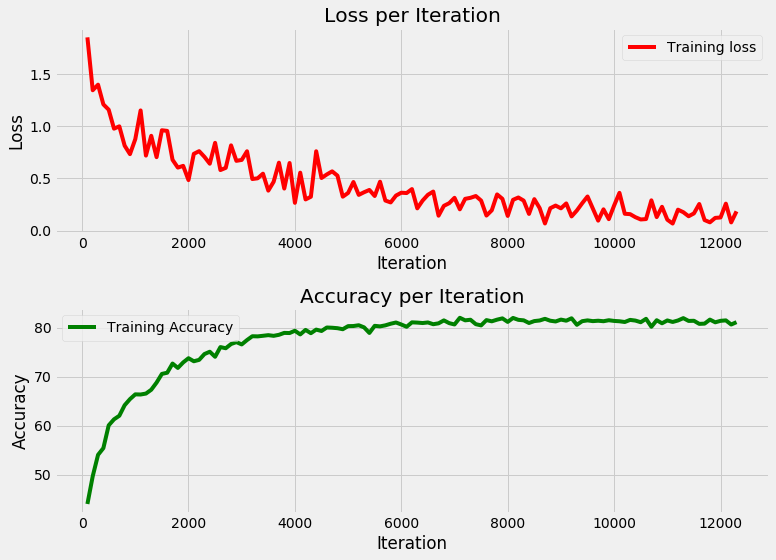

In [8]:
plot_both_loss(loss_list, accuracy_list, iteration_list)

## Number of Trainable Parameters

In [9]:
def count_parameters(model, grad):
    if grad:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

print('Total Parameters: ', count_parameters(model, False))
print('Total Trainable Parameters: ', count_parameters(model, True))

Total Parameters:  195738
Total Trainable Parameters:  195738


## Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
for images, labels in test_loader:
    images = Variable(images).to(device)
    labels = Variable(labels).to(device)  
    outputs = model(images)                
    predicted = torch.max(outputs.data, 1)[1]  
    y_true += labels.data.tolist()
    y_pred += predicted.data.tolist()
                       
cmatrix = confusion_matrix(y_true, y_pred)

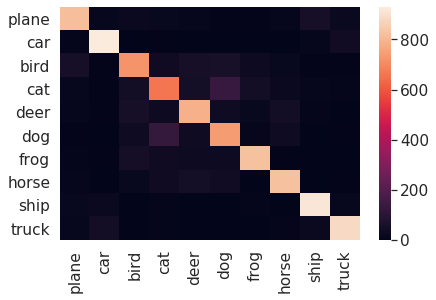

In [11]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cmatrix, classes, classes)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=False, annot_kws={"size": 16})

plt.show()

## Back-up ResNet